## Подготовка

Загрузим все необходимые библиотеки

In [1]:
import re
import nltk
import spacy
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

Загрузим датасет

In [3]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Выполним очистку текста и лемматизацию


In [5]:
corpus = df['text'].values.astype('U')

In [6]:
def clear_text(text):
    txt = re.sub(r'[^a-zA-Z ]', ' ', text) # оставляем только буквы английского алфавита
    txt = txt.split()                      # избавляемся от лишних пробелов разбиением текста
    txt = ' '.join(txt)                    # объединяем текст в предложения
    return txt
clear_corpus = []
for i in corpus:                     # проделываем это со всем корпусом
    cl = clear_text(i)
    clear_corpus.append(cl)


In [7]:
nlp = spacy.load('en_core_web_sm')
def lemma_it(row):
    sentence = row[0]
    doc = nlp(sentence)
    lemma_sent = " ".join([token.lemma_ for token in doc])
    return lemma_sent
    

Т.к. обработка нашего корпуса занимает около 50 минут, я выгружу лемматизированный корпус, а работу вышенаписанной функции закомментирую

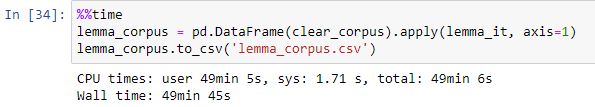

In [8]:
lemma_corpus = pd.read_csv('lemma_corpus.csv')
null_str = lemma_corpus.columns.values    #т.к. первая строка ушла в название столбцов пересохраним ее в первое значение
lemma_corpus = np.vstack([null_str, lemma_corpus.values]) #и объединим с остальными
lemma_corpus = pd.DataFrame(lemma_corpus, columns=['index', 'text']).drop('index', axis=1)
lemma_corpus

,text
0,Explanation why the edit make under my usernam...
1,d aww he match this background colour I m seem...
2,hey man I m really not try to edit war it s ju...
3,More I can t make any real suggestion on impro...
4,you sir be my hero any chance you remember wha...
...,...
159566,and for the second time of ask when your view ...
159567,you should be ashamed of yourself that be a ho...
159568,Spitzer Umm there s no actual article for pros...
159569,and it look like it be actually you who put on...


Для дальнейшего разбиения датасета, на обучающий и тестовый, соеденим лемматизированные и очищенные тексты со значением "токсичности"

In [9]:
lemma_corpus['toxic'] = df['toxic']


Разобъем выборку:

In [10]:
df_train, df_test = train_test_split(lemma_corpus, test_size = 0.5, random_state=123)


Соотношение позитивных комментириев и негативных

In [11]:
all_d = df['toxic'].value_counts()[1]/df['toxic'].value_counts()[0]
train_d = df_train['toxic'].value_counts()[1]/df_train['toxic'].value_counts()[0]
test_d = df_test['toxic'].value_counts()[1]/df_test['toxic'].value_counts()[0]
display('Соотношение во всей выборке:', all_d)
display('Соотношение в обучающей выборке:', train_d)
display('Соотношение в тестовой выборке:', test_d)

'Соотношение во всей выборке:'

0.1131876717871444

'Соотношение в обучающей выборке:'

0.11453356801609253

'Соотношение в тестовой выборке:'

0.11184503901895207

Соотношение негативных и позитивных сообщений сохранилось

Чтобы почистить мешок слов, найдём стоп-слова с помощью модуля nltk

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим признаки с помощью TF-IDF отдельно для обучающей и тестовой выборки (чтобы не учесть в модели частоты слов из тестовой выборки)

In [13]:
def tf_idf(corpus_train, corpus_test):
    tf_idf = TfidfVectorizer(stop_words=stop_words)                                     # векторизируем отбрасывая стоп-слова
    count_tf_idf_train = tf_idf.fit_transform(corpus_train.apply(lambda x: np.str_(x))) # трансформируем обучающую выборку
    
    count_tf_idf_test = tf_idf.transform(corpus_test.apply(lambda x: np.str_(x)))       # и тестовую выборку
    return count_tf_idf_train, count_tf_idf_test
tf_idf_train, tf_idf_test = tf_idf(df_train['text'], df_test['text'])

Выделим признаки и целевой признак:

In [14]:
features_train = tf_idf_train
features_test = tf_idf_test
target_train = df_train['toxic']
target_test = df_test['toxic']

Проверим размеры выборок

In [15]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(79785, 103827)

(79786, 103827)

(79785,)

(79786,)

## Обучение

Обучим разные модели и вычислим F1 метрику

Создадим функцию для обучения модели и вычисления метрики. Она будет принемать классификатор и возвращать велечину F1

In [16]:
def predict(cls):                                 
    model = cls.fit(features_train, target_train)
    predictions = model.predict(features_test)
    score = f1_score(target_test, predictions)
    return score


Попробуем логистическую регрессию:

In [17]:
lr = predict(LogisticRegression())
lr

0.7253317065731278

Неплохо, но недостаточно. Теперь дерево решений:

In [18]:
%%time
dtc = predict(DecisionTreeClassifier())
dtc

CPU times: user 3min 48s, sys: 0 ns, total: 3min 48s
Wall time: 3min 52s


0.7121051647872406

Результат хуже и очень медленно. Случайный лес:

In [19]:
rf = predict(RandomForestClassifier())
rf

0.6542816137777069

Еще хуже.

Попробуем улучшить логистическую регрессию:

In [20]:
lr_l1 = predict(LogisticRegression(penalty='l1'))
lr_l1

0.7719966159052452

Приемлемый результат

## Выводы

Когда данных много, то промодерировать большой объем текстовой информации может быть очень времязатратно или вовсе невозможно. В таких случаях приходят подобные методы, которые проанализируют текст значительно быстрее армии модераторов. В данном случае использование логистической регрессии с небольшими настройками гиперпараметров дают правильный результат (почти) в 4 случаях из 5 комментариев пользователей

In [21]:
res = pd.DataFrame([
                    ['Дерево решений', dtc],
                    ['Случайный лес', rf],
                    ['Логистическая регрессия', lr],
                    ['Логистическая регрессия l1', lr_l1]
                   ], columns = ['Модель','F1'])

res

,Модель,F1
0,Дерево решений,0.712105
1,Случайный лес,0.654282
2,Логистическая регрессия,0.725332
3,Логистическая регрессия l1,0.771997
